<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qubit-example" data-toc-modified-id="Qubit-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qubit example</a></span></li><li><span><a href="#Generating-Data" data-toc-modified-id="Generating-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating Data</a></span></li><li><span><a href="#Creating-the-Model" data-toc-modified-id="Creating-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the Model</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><span><a href="#1-Qubit" data-toc-modified-id="1-Qubit-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>1 Qubit</a></span></li><li><span><a href="#2-Qubits" data-toc-modified-id="2-Qubits-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>2 Qubits</a></span></li></ul></li></ul></div>

# Qubit example

Here we reproduce the result of tomography qubits from the [Iten and Metger et al. paper](https://arxiv.org/abs/1807.10300).

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 

from Models.VAE_Keras import Scinet_VariationalAutoencoder_Keras

import numpy as np
import matplotlib.pyplot as plt

# Generating Data

Data generation taken from [this github repository](https://github.com/eth-nn-physics/nn_physical_concepts)

In [16]:
from scipy.stats import unitary_group

def random_state(qubit_num):
    return unitary_group.rvs(2**qubit_num)[:, 0]


def random_subspace_states(qubit_num, k, states_num):
    """
    qubit_num: number of qubits
    k: number of orthogonal basis vectors
    states_num: number of states randomly sampled from subspace
    """

    assert(2 * 2**qubit_num > k)
    output_states = []
    subspace_basis = (unitary_group.rvs(2**qubit_num)[:, :k]).T
    for _ in range(states_num):
        c = np.random.rand(k) - 0.5
        linear_combination = 0.j
        for i in range(k):
            linear_combination += c[i] * subspace_basis[i]
        output_states.append(linear_combination / np.linalg.norm(linear_combination))
    return output_states


def projection(a, b):
    return np.abs(np.dot(np.conj(a), b))**2


def create_data(qubit_num, measurement_num1, measurement_num2, sample_num, file_name=None, incomplete_tomography=[False, False]):
    """
    ----------------------------------------------------------------------------
    Params:
    qubit_num: number of qubits
    measurement_num1: number of projective measurements to be performed on input qubit
    measurement_num2: number of projective measurements to be performed on projection axis
    sample_num: number of training examples to be generated
    file_name: file is stored in /data/file_name.pkl.gz
    incomplete_tomography: if the i-th entry is k, then the states for the projectors M_i 
                           are sampled from a k-dimensional real subspace
    """
    states_in1 = np.empty([sample_num, 2**qubit_num], dtype=np.complex_)
    states_in2 = np.empty([sample_num, 2**qubit_num], dtype=np.complex_)
    meas_res1 = np.empty([sample_num, measurement_num1], dtype=np.float_)
    meas_res2 = np.empty([sample_num, measurement_num2], dtype=np.float_)
    output = np.empty([sample_num, 1])
    if incomplete_tomography[0]:
        fixed_states_in1 = random_subspace_states(qubit_num, incomplete_tomography[0], measurement_num1)
    else:
        fixed_states_in1 = [random_state(qubit_num) for _ in range(measurement_num1)]
        
    if incomplete_tomography[1]:
        fixed_states_in2 = random_subspace_states(qubit_num, incomplete_tomography[1], measurement_num2)
        
    else:
        fixed_states_in2 = [random_state(qubit_num) for _ in range(measurement_num2)]
    for i in range(sample_num):
        states_in1[i] = random_state(qubit_num)
        states_in2[i] = random_state(qubit_num)
        meas_res1[i] = np.array([projection(s1, states_in1[i]) for s1 in fixed_states_in1])
        meas_res2[i] = np.array([projection(s2, states_in2[i]) for s2 in fixed_states_in2])
        output[i, 0] = projection(states_in1[i], states_in2[i])
    result = ([meas_res1, meas_res2, output], [states_in1, states_in2], [fixed_states_in1, fixed_states_in2])

    return result

# Creating the Model

In [134]:
def Reconstruc_Qubits(ZDIM, ipdim, qdim, LR=1e-3, B=1e-4):
    """Returns the Root of the B-VAE 
    Loss function
    
    Parameters
    ----------------------------------------
    ZDIM(int): Dimension of the latent space
    ipdim(int): Input dimension.
    1dim(int): Latent dimension.
    LR(float): Learning Rate. (default=1e-3)
    B(float): Beta parameter. (default=1e-4)
    
    """
    
    
    # run params
    SECTION = 'bvae'
    RUN_ID = '0001'
    DATA_NAME = '{}_qubit_{}'.format(qubit_n,ZDIM)
    RUN_FOLDER = 'run/{}/'.format(SECTION)
    RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])
    
    if not os.path.exists(RUN_FOLDER):
        os.makedirs(RUN_FOLDER)
        os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
        os.mkdir(os.path.join(RUN_FOLDER, 'images'))
        os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    
    mode =  'build'
    
    vae = Scinet_VariationalAutoencoder_Keras(
    input_dim = (ipdim,)
        , encoder_dense_units = [1024,512,256,128]
        , decoder_dense_units = [128,256,512,1024,1]
        , z_dim = ZDIM
        , q_dim = (qdim,)
    )
    
    if mode == 'build':
        vae.save(RUN_FOLDER)
    else:
        vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
        
    #Compile Parameters
    
    LEARNING_RATE = LR
    R_LOSS_FACTOR = 1
    BETA = B
    
    vae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)
    
    # Training Parameters
    
    BATCH_SIZE = 256
    EPOCHS = 20
    PRINT_EVERY_N_BATCHES = 100
    INITIAL_EPOCH = 0
    
    vae.train(     
              [training_data[0],training_data[1]]
            , training_data[2]
            , batch_size = BATCH_SIZE
            , epochs = EPOCHS
            , run_folder = RUN_FOLDER
            , print_every_n_batches = PRINT_EVERY_N_BATCHES
            , initial_epoch = INITIAL_EPOCH
            , verbose=0
             )
    
    return np.sqrt(vae.model.evaluate([validation_data[0],validation_data[1]], validation_data[2])[0])

# Examples

## 1 Qubit

In [17]:
#simulation parameters
qubit_n = 1
meas_num1 = 10
meas_num2 = 10
samples = 10000

validation_size_p = 5 # % of validation set

In [18]:
%timeit
data, states, params = create_data(qubit_num=qubit_n, 
                                measurement_num1=meas_num1, 
                                measurement_num2=meas_num2, 
                                sample_num=samples, 
                                )

In [19]:
states = np.array(states)
train_val_separation = int(len(data[0]) * (1 - validation_size_p / 100.))
training_data = [data[i][:train_val_separation] for i in [0, 1, 2]]
training_states = states[:train_val_separation]
validation_data = [data[i][train_val_separation:] for i in [0, 1, 2]]
validation_states = states[train_val_separation:]

In [ ]:
ZDIM_MAX = 5
LOSS = []
for i in np.arange(1,ZDIM_MAX,1):
    print("Latent Dimension: {}".format(i))
    LOSS.append(Reconstruc_Qubits(i,meas_num1,meas_num2))

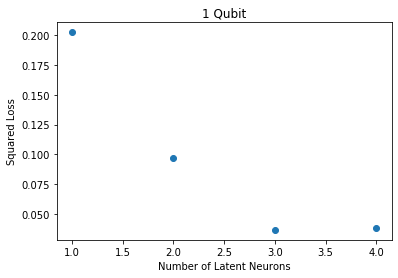

In [120]:
plt.title('1 Qubit');
plt.xlabel('Number of Latent Neurons');
plt.ylabel('Root Loss');
plt.plot(np.arange(1,ZDIM_MAX,1),LOSS, 'o');

## 2 Qubits

In [128]:
#simulation parameters
qubit_n = 2
meas_num1 = 30
meas_num2 = 30
samples = 10000

validation_size_p = 5 # % of validation set

In [129]:
data, states, params = create_data(qubit_num=qubit_n, 
                                measurement_num1=meas_num1, 
                                measurement_num2=meas_num2, 
                                sample_num=samples, 
                                )

In [130]:
states = np.array(states)
train_val_separation = int(len(data[0]) * (1 - validation_size_p / 100.))
training_data = [data[i][:train_val_separation] for i in [0, 1, 2]]
training_states = states[:train_val_separation]
validation_data = [data[i][train_val_separation:] for i in [0, 1, 2]]
validation_states = states[train_val_separation:]

In [ ]:
ZDIM_MAX = 10
LOSS = []
for i in np.arange(1,ZDIM_MAX,1):
    print("Latent Dimension: {}".format(i))
    LOSS.append(Reconstruc_Qubits(i,meas_num1,meas_num2))

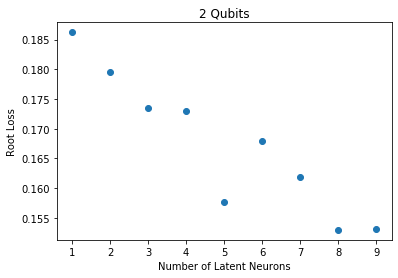

In [137]:
plt.title('2 Qubits');
plt.xlabel('Number of Latent Neurons');
plt.ylabel('Root Loss');
plt.plot(np.arange(1,ZDIM_MAX,1),LOSS, 'o');